In [1]:
import torch.utils.data as tdata
import torch
import numpy as np
from pathlib import Path

In [2]:
class Dataset0D(tdata.Dataset):
    
    def __init__(self, input_file, output_file):
        self.input = np.load(input_file)
        self.output= np.load(output_file)
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]).float(), torch.from_numpy(self.output[idx]).float()


In [3]:
dir = Path('../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0')

sim_dataset = Dataset0D(dir / 'training_data' / 'input.npy', dir / 'training_data' / 'output.npy')

In [4]:
inp, out = sim_dataset[0]

In [5]:
import matplotlib.pyplot as plt

# Check Uniformity of Input

(array([630., 631., 630., 630., 630., 630., 630., 630., 631., 630., 630.,
        630., 631., 630., 630., 630., 630., 630., 630., 630., 630., 630.,
        630., 630., 630., 631.]),
 array([1.00006653, 1.06090917, 1.1217518 , 1.18259443, 1.24343707,
        1.3042797 , 1.36512233, 1.42596497, 1.4868076 , 1.54765023,
        1.60849287, 1.6693355 , 1.73017813, 1.79102077, 1.8518634 ,
        1.91270603, 1.97354867, 2.0343913 , 2.09523393, 2.15607657,
        2.2169192 , 2.27776183, 2.33860447, 2.3994471 , 2.46028973,
        2.52113237, 2.581975  ]),
 <BarContainer object of 26 artists>)

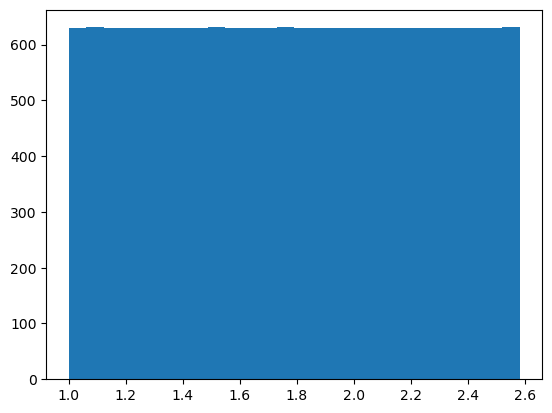

In [6]:
# uniform
plt.hist(sim_dataset.input[:, 3], bins = 'auto')

# Check Distributions of individual Pressures and FLows

In [7]:
from scipy.stats import norm
import scipy.stats as stats

In [8]:
def sep_QF(out):
    ''' for a single sample, seperates pressures,flows'''
    return out[::2], out[1::2]


In [9]:
from ipywidgets import interact, fixed

In [26]:
def plot_point_data(point, dataset):
    point*=2
    pressures = sim_dataset.output[:, point]
    flows = sim_dataset.output[:, point+1]
    
    
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    ax = ax.flatten()
    stats.probplot(pressures, dist = 'norm',plot = ax[0])
    
    ax[1].hist(pressures, bins = 'auto', density=True)
    x_min, x_max = ax[1].get_xlim()
    x = np.linspace(x_min, x_max, 100)
    mean, std = norm.fit(pressures)
    ax[1].plot(x, norm.pdf(x, mean, std ))
    ax[1].set_title('Pressures')
    
    stats.probplot(flows, dist = 'norm',plot = ax[2])
    
    ax[3].hist(flows, bins = 'auto', density=True)
    x_min, x_max = ax[3].get_xlim()
    x = np.linspace(x_min, x_max, 100)
    mean, std = norm.fit(flows)
    ax[3].plot(x, norm.pdf(x, mean, std ))
    ax[3].set_title("Flows")
    fig.suptitle(f'Distributions for vessel {point}')
    
    fig.show()

C:\Users\johnd\AppData\Local\Temp\ipykernel_20268\2616170309.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


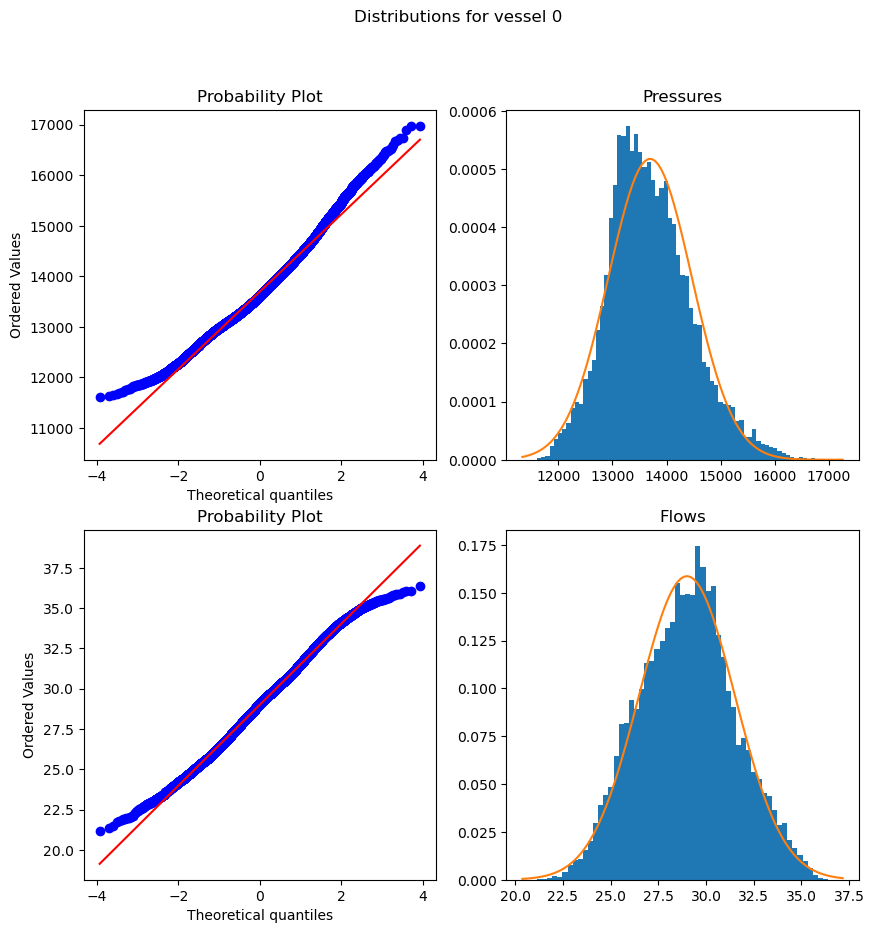

In [30]:
plot_point_data(0, sim_dataset)

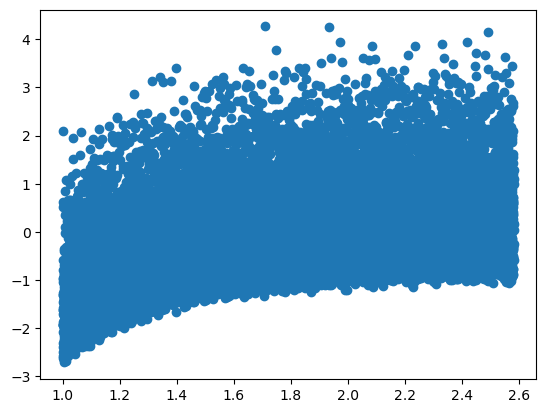

In [36]:
point = 0
plt.scatter(sim_dataset.input[:,point], sim_dataset.output[:,point])

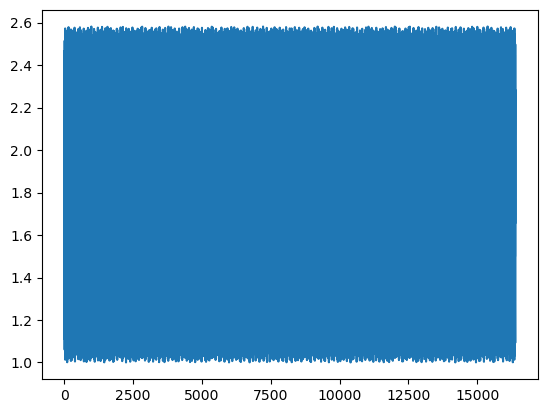

In [20]:
plt.plot(range(len(sim_dataset.input[:, 0]) ), sim_dataset.input[:, 3])

In [32]:
output = sim_dataset.output

In [34]:
output[:,0] = (output[:,0] - output[:, 0].mean()) / output[:, 0].std()

In [35]:
output

array([[-5.67955649e-01,  3.06808917e+01,  1.28265813e+04, ...,
         1.22762519e+00,  1.17011370e+04,  1.38549904e+00],
       [ 4.46257061e-01,  3.22753583e+01,  1.39230164e+04, ...,
         1.48807645e+00,  1.44162892e+04,  2.11895025e+00],
       [ 3.40073500e-01,  2.90715257e+01,  1.24981103e+04, ...,
         1.22968290e+00,  1.01242250e+04,  9.59082841e-01],
       ...,
       [-8.62399045e-01,  2.87447712e+01,  1.29471677e+04, ...,
         1.16417797e+00,  1.27196582e+04,  1.66074228e+00],
       [-4.79952805e-01,  2.64830800e+01,  1.19931866e+04, ...,
         1.18199324e+00,  1.24367657e+04,  1.58426260e+00],
       [ 2.00913218e+00,  2.82347258e+01,  1.50644731e+04, ...,
         1.16805308e+00,  1.41746363e+04,  2.05365911e+00]])

#

# Model Testing

In [1]:
import sys
sys.path.append('..')
from scripts.ml_scripts.nn_model import *

from pathlib import Path
import torch
from torch import nn
import pytorch_lightning as pl
import numpy as np
import os
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# data
dir = Path('../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0')
sim_dataset = Dataset0D(dir / 'training_data' / 'input.npy', dir / 'training_data' / 'output.npy', normalization)

In [3]:
# load through torch
test_loader = torch.load(dir / "training_data" / "test_dataloader.pt")

In [119]:
class PredictConfig(LightningNN):
    
    def __init__(self, revert_map, model) -> None:
        super().__init__(model, lr = 0)
        self.revert_map = revert_map
        
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        revert(y_hat, self.revert_map)
        revert(y, self.revert_map)

        return torch.stack((y, y_hat), dim = 1)

In [120]:
input_data, output_data = sim_dataset[0]
nnmodel = BasicNN(input_neurons=len(input_data), output_neurons=len(output_data), hidden_layers=3, neurons_per_layer=1000)
litmodel = PredictConfig(sim_dataset.revert_map, nnmodel)

In [121]:
all_results_folder = dir / 'training_results'
if not os.path.exists(all_results_folder):
    os.mkdir(all_results_folder)

cur_results_folder = all_results_folder / 'test1'
if not os.path.exists(cur_results_folder):
    os.mkdir(cur_results_folder)

In [122]:
trainer = pl.Trainer( max_epochs=100, accelerator="gpu", default_root_dir=cur_results_folder, log_every_n_steps=5)#, fast_dev_run=True)
rez = trainer.predict(model=litmodel, dataloaders=test_loader, ckpt_path= dir / "training_results" / "run1" / "lightning_logs" / "version_25" / "checkpoints" / "epoch=99-step=10300.ckpt", return_predictions=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ..\data\healthy\0080_0001\jc_solver_dir_0\artificial_stenosis\Manual_0\training_results\run1\lightning_logs\version_25\checkpoints\epoch=99-step=10300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ..\data\healthy\0080_0001\jc_solver_dir_0\artificial_stenosis\Manual_0\training_results\run1\lightning_logs\version_25\checkpoints\epoch=99-step=10300.ckpt


Predicting: 0it [00:00, ?it/s]

In [67]:
import matplotlib.pyplot as plt

In [ ]:
def d2m(val):
    return val / 1333.22

In [ ]:
rez = torch.vstack(rez)

In [ ]:
residuals = rez[:,1] - rez[:, 2]

In [ ]:
def plot_residuals(x, residuals, vessel):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 8))
    
    ax[0].set_title('Pressure (mmHg) Residuals')
    ax[0].plot()

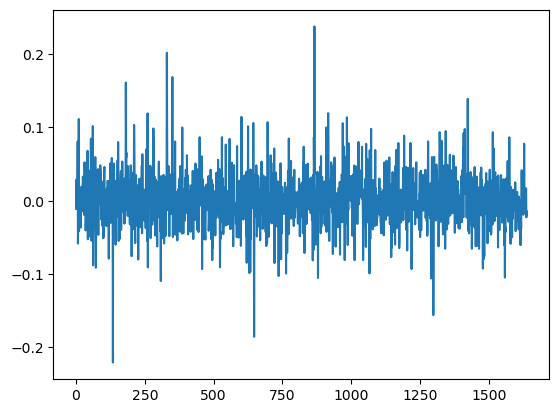

In [114]:
plt.plot(d2m(residuals[:, 0]))